In [0]:
COLAB = True # NOTE change me if not running on Colab :D

## Importing libs

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [4]:
if COLAB:
    try:
        # Colab only
        %tensorflow_version 2.x
    except Exception:
        pass

TensorFlow 2.x selected.


In [5]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [0]:
import warnings
from time import time, strftime

In [7]:
strftime('%X')

'20:43:02'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [8]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
if COLAB:
    PATH_TO_DATA = os.path.join("drive", "My Drive", "unicamp", "%ic", "mc886", "fashion-mnist-dataset")
    !ls drive/My\ Drive/unicamp/%ic/mc886/fashion-mnist-dataset/
else:
    PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")
    !ls ../fashion-mnist-dataset/

fashion-mnist_test.csv	fashion-mnist_train.csv  README.txt


In [0]:
# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [0]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [0]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [13]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [14]:
ys_train = train_dataset["label"].values
ys_val   = validation_dataset["label"].values
ys_test  = test_dataset["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [15]:
xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [0]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [17]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4863 (0.10%)  1137 (0.09%)  1000 (0.10%)
Trouser:      4795 (0.10%)  1205 (0.10%)  1000 (0.10%)
Pullover:     4817 (0.10%)  1183 (0.10%)  1000 (0.10%)
Dress:        4770 (0.10%)  1230 (0.10%)  1000 (0.10%)
Coat:         4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Sandal:       4769 (0.10%)  1231 (0.10%)  1000 (0.10%)
Shirt:        4771 (0.10%)  1229 (0.10%)  1000 (0.10%)
Sneaker:      4764 (0.10%)  1236 (0.10%)  1000 (0.10%)
Bag:          4778 (0.10%)  1222 (0.10%)  1000 (0.10%)
Ankle boot:   4853 (0.10%)  1147 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [0]:
xs_train = xs_train.astype('float32') / 255.0
xs_val   = xs_val.astype('float32')   / 255.0
xs_test  = xs_test.astype('float32')  / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [19]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2862, stddev= 0.3529
X_train:  mean=  0.0000, stddev= 1.0000


In [20]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2858, stddev= 0.3526
X_val:  mean= -0.0011, stddev= 0.9992


In [0]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [22]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [23]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


_obs.:_ `Y_foo` is only a one-hot encoded version of `ys_foo` (so we use `ys_foo` in some places below, to avoid calling `np.argmax`)

## Add helper functions

In [0]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [0]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, f1_score

In [0]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l1, l2

In [0]:
MAX_EPOCHS = 64
BATCH_SIZE = 512
TF_VERBOSE = 1 # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [0]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = ([keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
                 if not early_stopping else
                 [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True),
                  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)])
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=TF_VERBOSE
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

### 1.1. MLP

In [0]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [0]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [35]:
strftime('%X')

'20:43:57'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 2s 52us/sample - loss: 0.6591 - accuracy: 0.7755 - val_loss: 0.4636 - val_accuracy: 0.8386
Epoch 2/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.4152 - accuracy: 0.8577 - val_loss: 0.4015 - val_accuracy: 0.8599
Epoch 3/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3760 - accuracy: 0.8704 - val_loss: 0.3916 - val_accuracy: 0.8642
Epoch 4/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3442 - accuracy: 0.8801 - val_loss: 0.3674 - val_accuracy: 0.8714
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3317 - accuracy: 0.8852 - val_loss: 0.3675 - val_accuracy: 0.8708
Epoch 6/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3128 - accuracy: 0.8915 - val_loss: 0.3620 - val_accuracy: 0.8732
Epoch 7/64
48000/48000 [===========

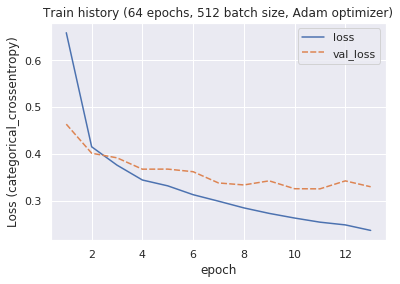

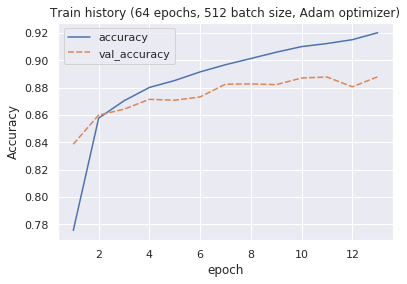

In [36]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val)

In [37]:
strftime('%X')

'20:44:09'

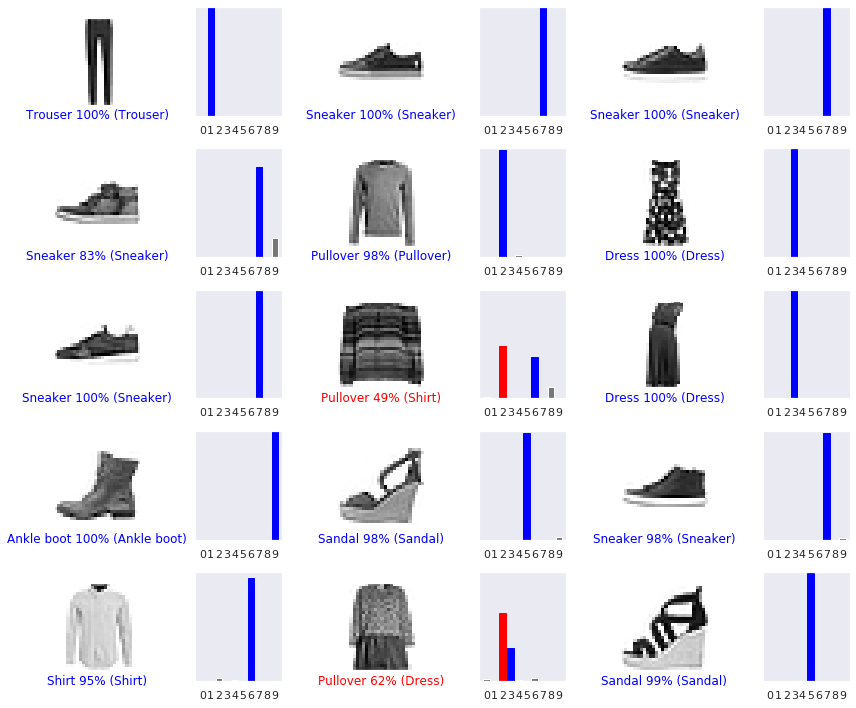

In [38]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

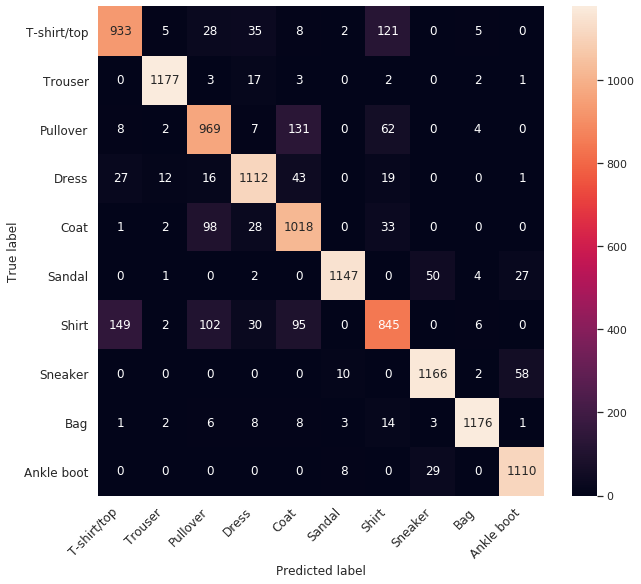

In [39]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

### 1.2. CNN

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [0]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [42]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [43]:
conv_model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

In [44]:
strftime('%X')

'20:44:14'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 127us/sample - loss: 0.7265 - accuracy: 0.7582 - val_loss: 0.4630 - val_accuracy: 0.8457
Epoch 2/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.4346 - accuracy: 0.8534 - val_loss: 0.4269 - val_accuracy: 0.8489
Epoch 3/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3875 - accuracy: 0.8722 - val_loss: 0.3739 - val_accuracy: 0.8803
Epoch 4/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3524 - accuracy: 0.8842 - val_loss: 0.3543 - val_accuracy: 0.8869
Epoch 5/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3334 - accuracy: 0.8903 - val_loss: 0.3356 - val_accuracy: 0.8941
Epoch 6/64
48000/48000 [==============================] - 2s 49us/sample - loss: 0.3152 - accuracy: 0.8989 - val_loss: 0.3362 - val_accuracy: 0.8863
Epoch 7/64
48000/48000 [==========

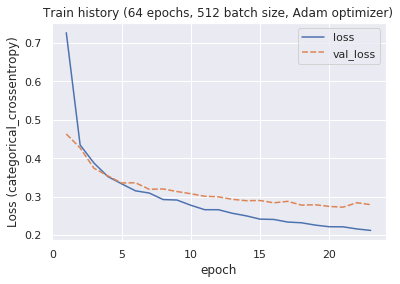

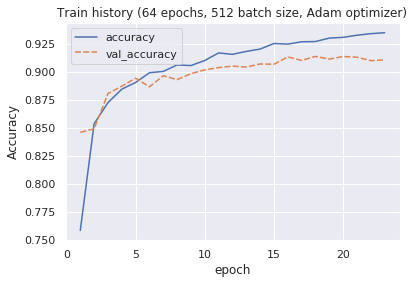

In [45]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val)

In [46]:
strftime('%X')

'20:45:14'

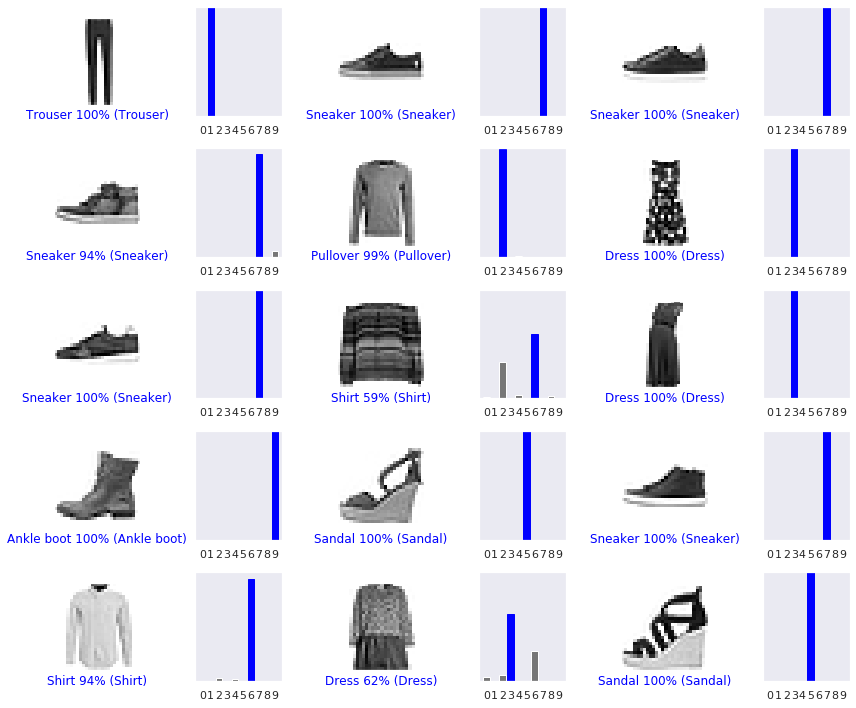

In [47]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

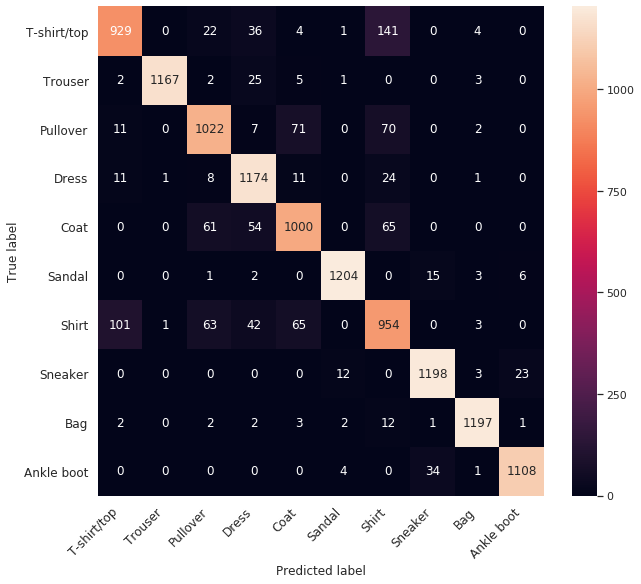

In [48]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [0]:
from sklearn.decomposition import PCA

In [0]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [51]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.02 | mean: 0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: int64   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.495 | std: 2.879


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [0]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [0]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

### 2.1. 99% explained variance

In [54]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.9900491237640381 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.8250 - accuracy: 0.7336 - val_loss: 0.4504 - val_accuracy: 0.8497
Epoch 2/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3940 - accuracy: 0.8681 - val_loss: 0.3871 - val_accuracy: 0.8698
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3374 - accuracy: 0.8887 - val_loss: 0.3679 - val_accuracy: 0.8759
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3008 - accuracy: 0.9014 - val_loss: 0.3534 - val_accuracy: 0.8803
Epoch 5/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2734 - accuracy: 0.9110 - val_loss: 0.3463 - val_accuracy: 0.8827
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2496 - accuracy: 0.9200 - val_loss: 0.3436 - val_accuracy: 0.8820
Epoch 7/64
48000/48000 [===========

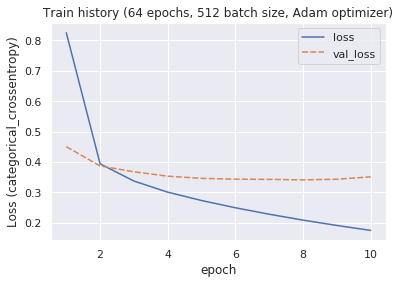

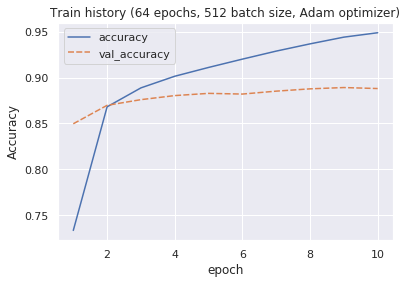

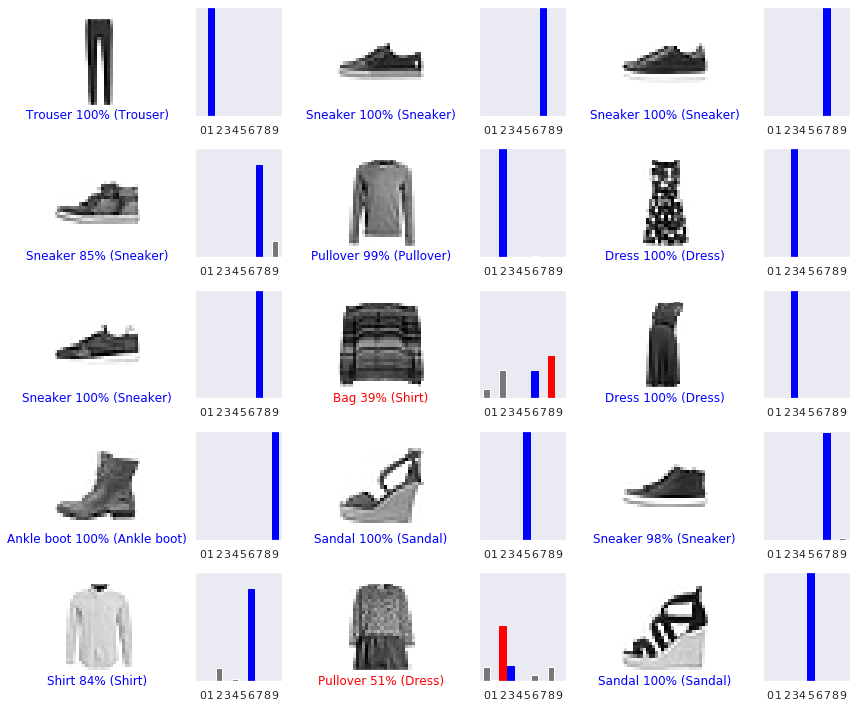

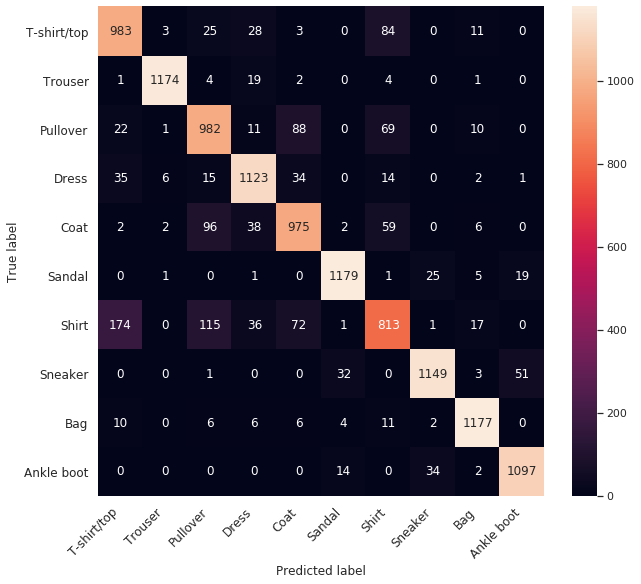

In [55]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

### 2.2. 95% explained variance

In [56]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9501577615737915 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.8179 - accuracy: 0.7370 - val_loss: 0.4618 - val_accuracy: 0.8472
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4149 - accuracy: 0.8614 - val_loss: 0.4041 - val_accuracy: 0.8650
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3631 - accuracy: 0.8786 - val_loss: 0.3730 - val_accuracy: 0.8747
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3311 - accuracy: 0.8892 - val_loss: 0.3575 - val_accuracy: 0.8763
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3081 - accuracy: 0.8979 - val_loss: 0.3547 - val_accuracy: 0.8835
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.2907 - accuracy: 0.9031 - val_loss: 0.3411 - val_accuracy: 0.8843
Epoch 7/64
48000/48000 [===========

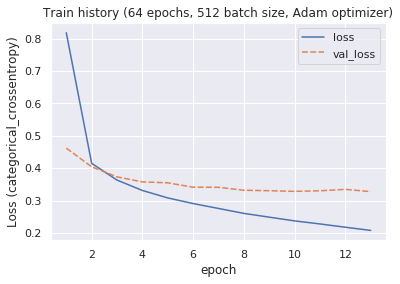

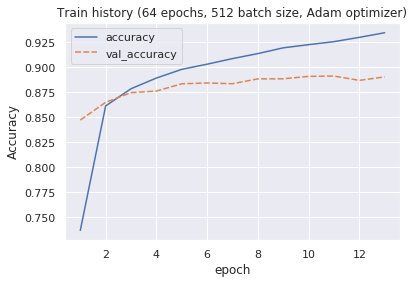

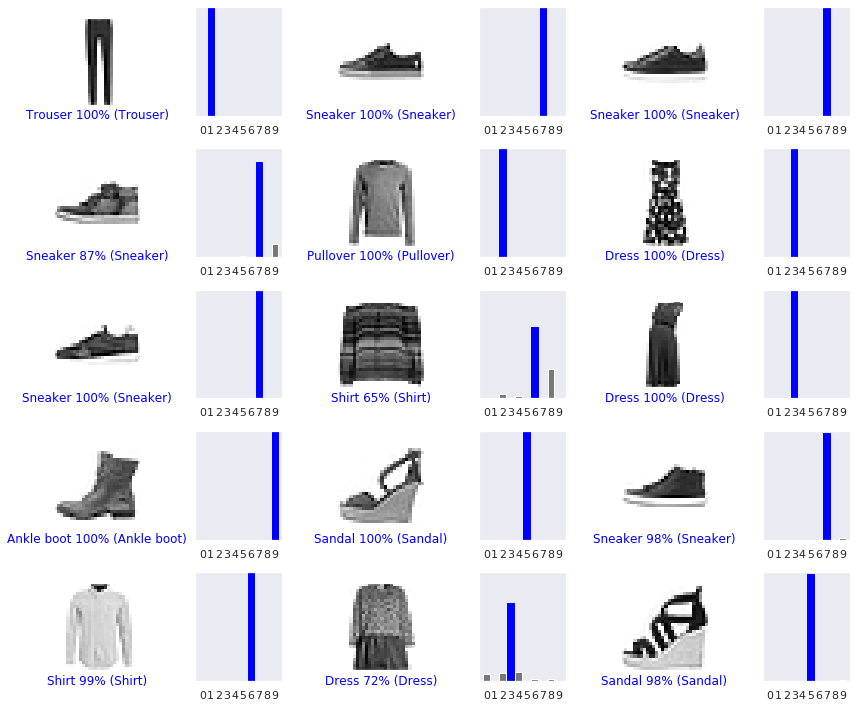

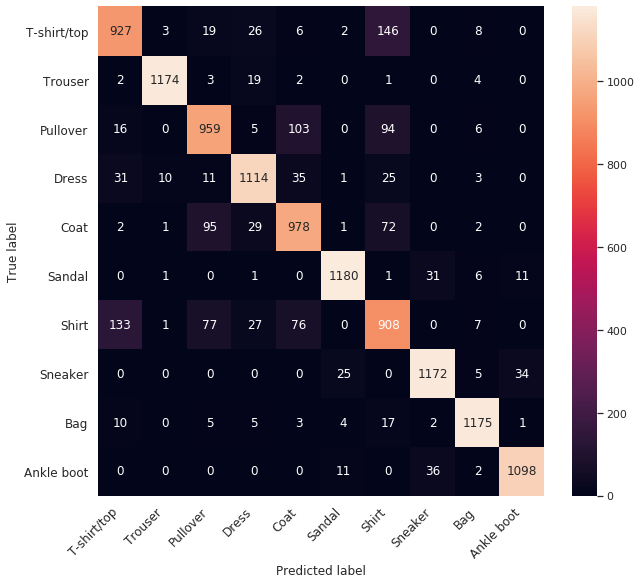

In [57]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

### 2.3. 90% explained variance

In [58]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006989598274231 explained variance
84 / 784 = 10.71% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 26us/sample - loss: 0.7980 - accuracy: 0.7354 - val_loss: 0.4843 - val_accuracy: 0.8331
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4359 - accuracy: 0.8515 - val_loss: 0.4158 - val_accuracy: 0.8562
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3863 - accuracy: 0.8687 - val_loss: 0.3867 - val_accuracy: 0.8668
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3590 - accuracy: 0.8769 - val_loss: 0.3740 - val_accuracy: 0.8709
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3399 - accuracy: 0.8849 - val_loss: 0.3633 - val_accuracy: 0.8724
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3260 - accuracy: 0.8892 - val_loss: 0.3541 - val_accuracy: 0.8798
Epoch 7/64
48000/48000 [===========

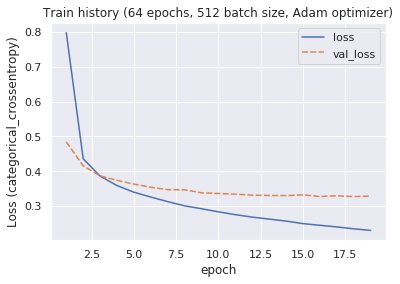

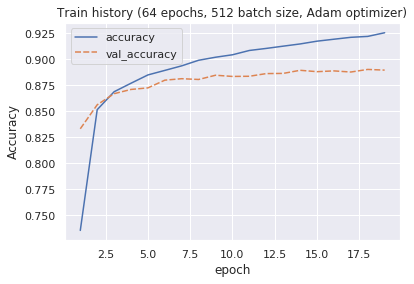

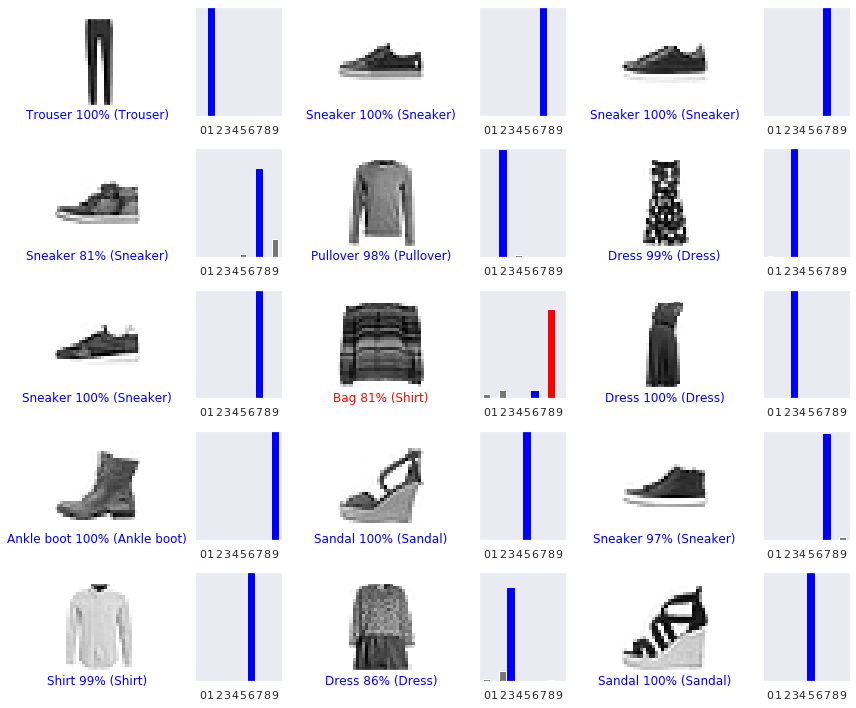

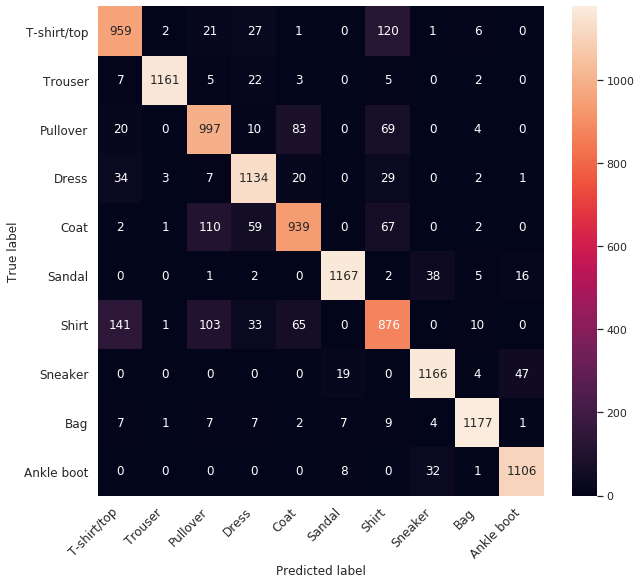

In [59]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

### 2.4. F1-scores

In [0]:
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {len(f1_score) / sum(1 / max(v, 1e-18) for v in f1_score):.4f}")
    print(f"Combined Precision: {len(precision) / sum(1 / max(v, 1e-18) for v in precision):.4f}")
    print(f"Combined Recall:    {len(recall) / sum(1 / max(v, 1e-18) for v in recall):.4f}")

In [62]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8338  |  0.8206  |  0.8271
Class 1 (Trouser):       0.9784  |  0.9768  |  0.9776
Class 2 (Pullover):      0.7930  |  0.8191  |  0.8058
Class 3 (Dress):         0.8975  |  0.9041  |  0.9008
Class 4 (Coat):          0.7795  |  0.8627  |  0.8190
Class 5 (Sandal):        0.9803  |  0.9318  |  0.9554
Class 6 (Shirt):         0.7710  |  0.6876  |  0.7269
Class 7 (Sneaker):       0.9343  |  0.9434  |  0.9388
Class 8 (Bag):           0.9808  |  0.9624  |  0.9715
Class 9 (Ankle boot):    0.9265  |  0.9677  |  0.9467

Combined F1 score:  0.8789
Combined Precision: 0.8798
Combined Recall:    0.8781


In [63]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8797  |  0.8171  |  0.8472
Class 1 (Trouser):       0.9983  |  0.9685  |  0.9832
Class 2 (Pullover):      0.8654  |  0.8639  |  0.8646
Class 3 (Dress):         0.8748  |  0.9545  |  0.9129
Class 4 (Coat):          0.8628  |  0.8475  |  0.8551
Class 5 (Sandal):        0.9837  |  0.9781  |  0.9809
Class 6 (Shirt):         0.7536  |  0.7762  |  0.7647
Class 7 (Sneaker):       0.9599  |  0.9693  |  0.9646
Class 8 (Bag):           0.9836  |  0.9795  |  0.9815
Class 9 (Ankle boot):    0.9736  |  0.9660  |  0.9698

Combined F1 score:  0.9064
Combined Precision: 0.9070
Combined Recall:    0.9058


In [64]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8011  |  0.8646  |  0.8316
Class 1 (Trouser):       0.9890  |  0.9743  |  0.9816
Class 2 (Pullover):      0.7894  |  0.8301  |  0.8092
Class 3 (Dress):         0.8899  |  0.9130  |  0.9013
Class 4 (Coat):          0.8263  |  0.8263  |  0.8263
Class 5 (Sandal):        0.9570  |  0.9578  |  0.9574
Class 6 (Shirt):         0.7706  |  0.6615  |  0.7119
Class 7 (Sneaker):       0.9488  |  0.9296  |  0.9391
Class 8 (Bag):           0.9538  |  0.9632  |  0.9585
Class 9 (Ankle boot):    0.9392  |  0.9564  |  0.9477

Combined F1 score:  0.8780
Combined Precision: 0.8795
Combined Recall:    0.8765


In [65]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8269  |  0.8153  |  0.8211
Class 1 (Trouser):       0.9866  |  0.9743  |  0.9804
Class 2 (Pullover):      0.8204  |  0.8107  |  0.8155
Class 3 (Dress):         0.9086  |  0.9057  |  0.9072
Class 4 (Coat):          0.8130  |  0.8288  |  0.8208
Class 5 (Sandal):        0.9641  |  0.9586  |  0.9613
Class 6 (Shirt):         0.7184  |  0.7388  |  0.7284
Class 7 (Sneaker):       0.9444  |  0.9482  |  0.9463
Class 8 (Bag):           0.9647  |  0.9615  |  0.9631
Class 9 (Ankle boot):    0.9598  |  0.9573  |  0.9585

Combined F1 score:  0.8821
Combined Precision: 0.8819
Combined Recall:    0.8824


In [66]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8197  |  0.8434  |  0.8314
Class 1 (Trouser):       0.9932  |  0.9635  |  0.9781
Class 2 (Pullover):      0.7970  |  0.8428  |  0.8192
Class 3 (Dress):         0.8764  |  0.9220  |  0.8986
Class 4 (Coat):          0.8437  |  0.7958  |  0.8190
Class 5 (Sandal):        0.9717  |  0.9480  |  0.9597
Class 6 (Shirt):         0.7443  |  0.7128  |  0.7282
Class 7 (Sneaker):       0.9396  |  0.9434  |  0.9415
Class 8 (Bag):           0.9703  |  0.9632  |  0.9667
Class 9 (Ankle boot):    0.9445  |  0.9643  |  0.9543

Combined F1 score:  0.8819
Combined Precision: 0.8823
Combined Recall:    0.8815


### 2.4. <90% explained variance

## 2.4.1. 80% explained variance

In [67]:
model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

24 principal components → 0.8008705377578735 explained variance
24 / 784 = 3.06% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 27us/sample - loss: 0.8291 - accuracy: 0.7186 - val_loss: 0.5476 - val_accuracy: 0.8092
Epoch 2/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.5029 - accuracy: 0.8258 - val_loss: 0.4803 - val_accuracy: 0.8344
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4575 - accuracy: 0.8417 - val_loss: 0.4542 - val_accuracy: 0.8422
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4335 - accuracy: 0.8510 - val_loss: 0.4373 - val_accuracy: 0.8469
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4165 - accuracy: 0.8566 - val_loss: 0.4276 - val_accuracy: 0.8503
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4067 - accuracy: 0.8595 - val_loss: 0.4200 - val_accuracy: 0.8535
Epoch 7/64
48000/48000 [===========

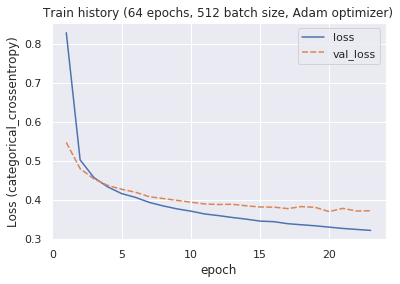

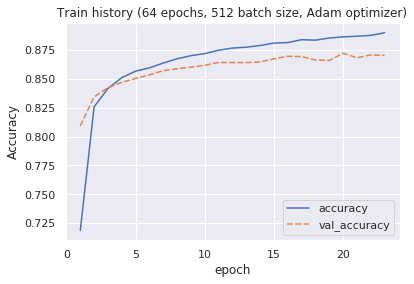

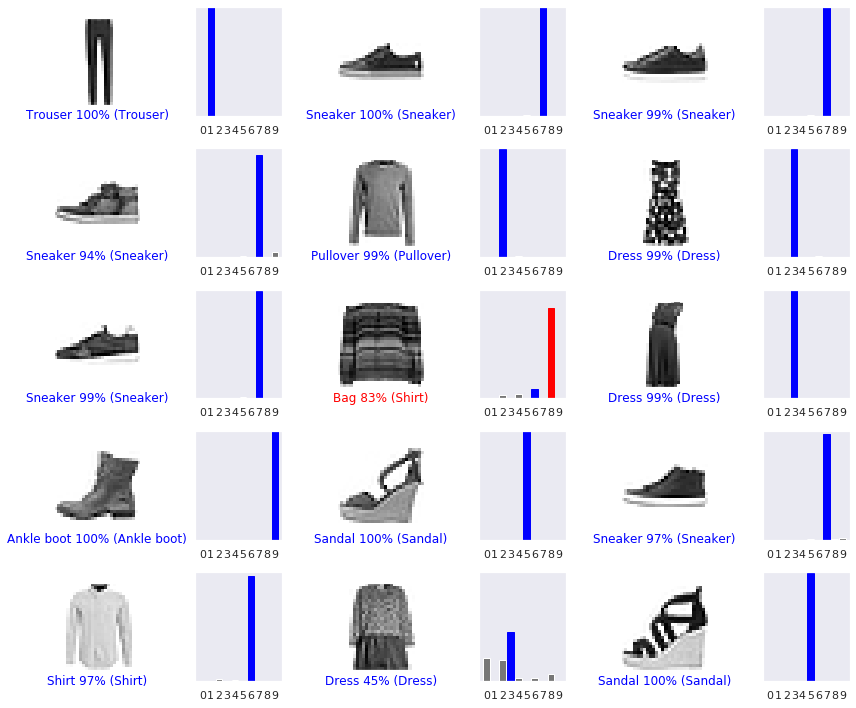

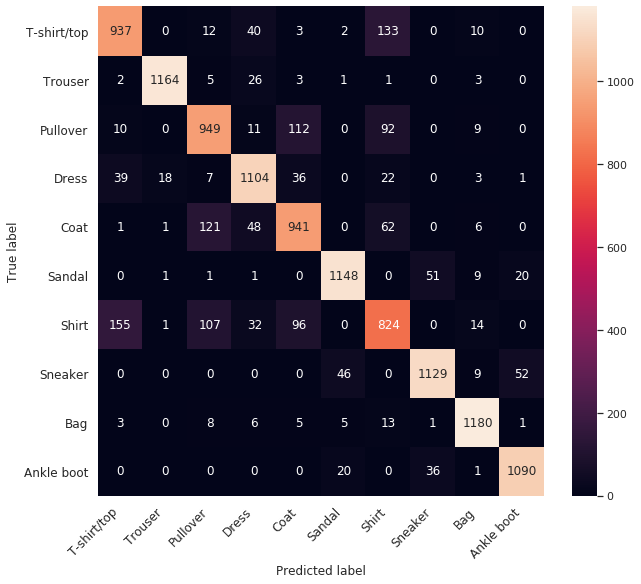

In [68]:
Y_val_80var_pred = train_pca_model(model_80var, pca_80var)

In [69]:
print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8169  |  0.8241  |  0.8205
Class 1 (Trouser):       0.9823  |  0.9660  |  0.9741
Class 2 (Pullover):      0.7843  |  0.8022  |  0.7931
Class 3 (Dress):         0.8707  |  0.8976  |  0.8839
Class 4 (Coat):          0.7868  |  0.7975  |  0.7921
Class 5 (Sandal):        0.9394  |  0.9326  |  0.9360
Class 6 (Shirt):         0.7184  |  0.6705  |  0.6936
Class 7 (Sneaker):       0.9277  |  0.9134  |  0.9205
Class 8 (Bag):           0.9486  |  0.9656  |  0.9570
Class 9 (Ankle boot):    0.9364  |  0.9503  |  0.9433

Combined F1 score:  0.8620
Combined Precision: 0.8626
Combined Recall:    0.8613


## 2.4.2. 60% explained variance

In [70]:
model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")

PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

5 principal components → 0.6156876087188721 explained variance
5 / 784 = 0.64% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 29us/sample - loss: 1.0064 - accuracy: 0.6447 - val_loss: 0.7868 - val_accuracy: 0.7057
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.7523 - accuracy: 0.7185 - val_loss: 0.7408 - val_accuracy: 0.7192
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.7238 - accuracy: 0.7257 - val_loss: 0.7142 - val_accuracy: 0.7260
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.7079 - accuracy: 0.7307 - val_loss: 0.7022 - val_accuracy: 0.7315
Epoch 5/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.6959 - accuracy: 0.7340 - val_loss: 0.6967 - val_accuracy: 0.7347
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.6891 - accuracy: 0.7361 - val_loss: 0.6966 - val_accuracy: 0.7358
Epoch 7/64
48000/48000 [===========

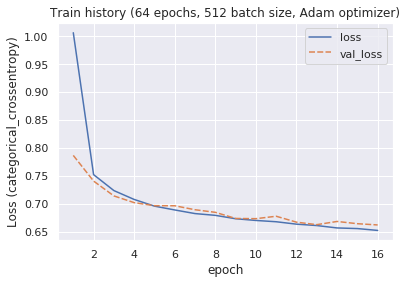

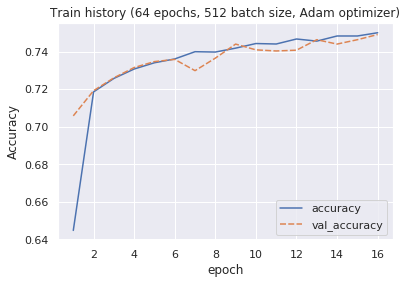

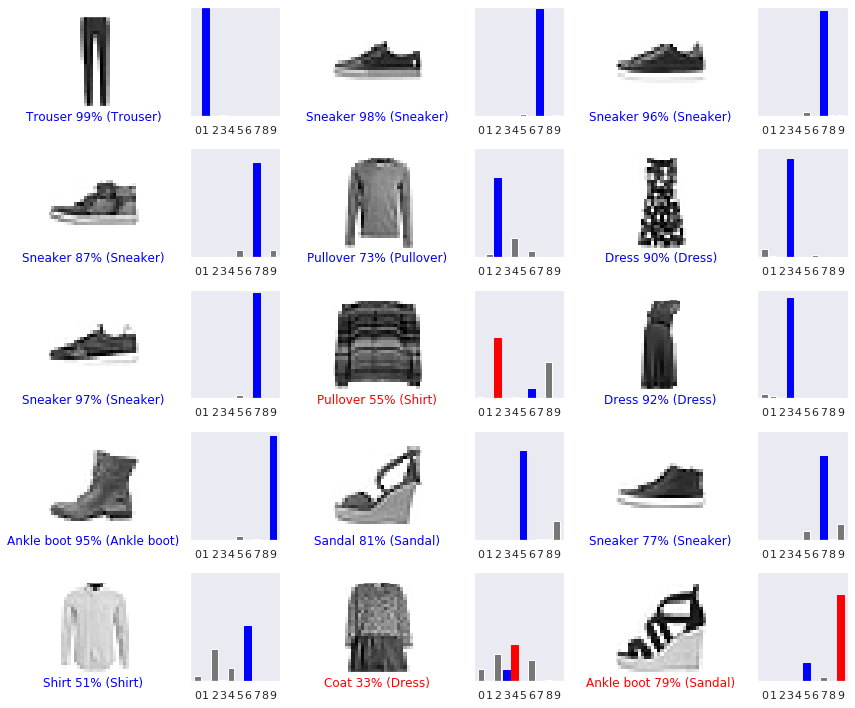

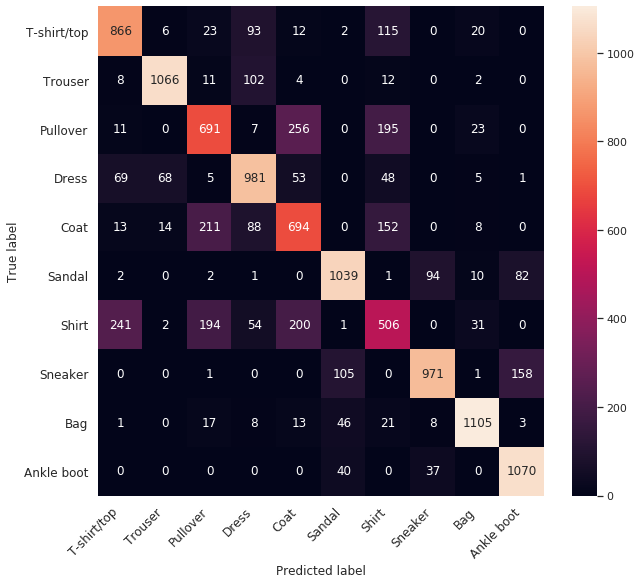

In [71]:
Y_val_60var_pred = train_pca_model(model_60var, pca_60var)

In [72]:
# 60% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7151  |  0.7617  |  0.7376
Class 1 (Trouser):       0.9221  |  0.8846  |  0.9030
Class 2 (Pullover):      0.5983  |  0.5841  |  0.5911
Class 3 (Dress):         0.7354  |  0.7976  |  0.7652
Class 4 (Coat):          0.5633  |  0.5881  |  0.5755
Class 5 (Sandal):        0.8427  |  0.8440  |  0.8433
Class 6 (Shirt):         0.4819  |  0.4117  |  0.4441
Class 7 (Sneaker):       0.8748  |  0.7856  |  0.8278
Class 8 (Bag):           0.9170  |  0.9043  |  0.9106
Class 9 (Ankle boot):    0.8143  |  0.9329  |  0.8696

Combined F1 score:  0.7096
Combined Precision: 0.7136
Combined Recall:    0.7055


### 2.5. Plot the first 3 principal components

In [0]:
pca_3pc = PCA(n_components=3)

In [0]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [75]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variance per principal component:
PC 1: 0.2896 (cumulative sum: 0.29)
PC 2: 0.1775 (cumulative sum: 0.47)
PC 3: 0.0606 (cumulative sum: 0.53)


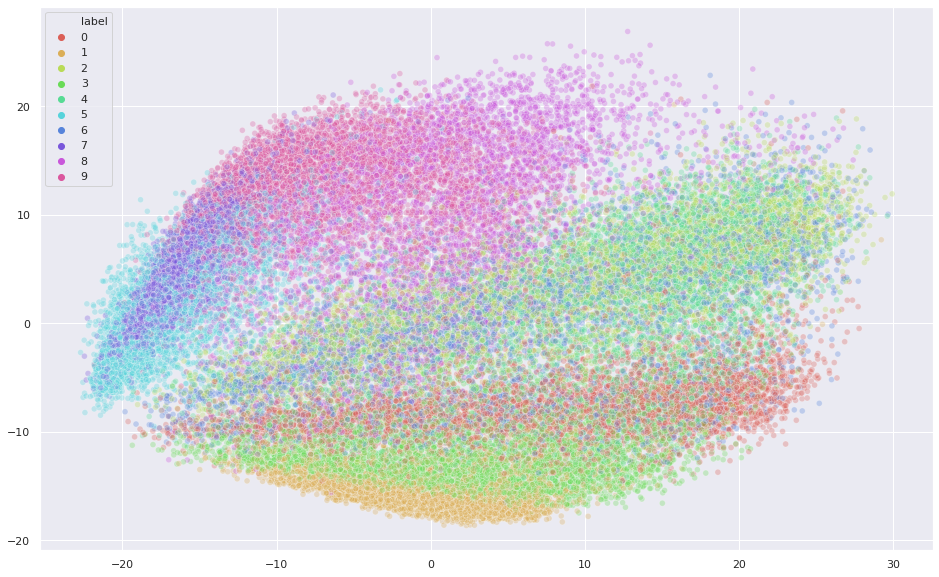

In [96]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=pca_3pc_result[..., 0], # PC 1
    y=pca_3pc_result[..., 1], # PC 2
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=train_dataset,
    legend="full",
    alpha=0.3
)

In [0]:
from mpl_toolkits.mplot3d import Axes3D

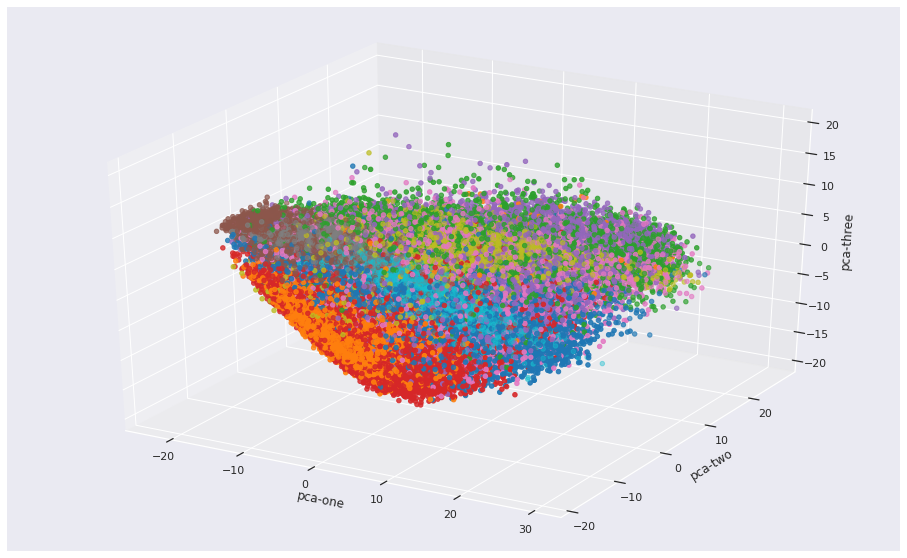

In [78]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


In [0]:
from tensorflow.keras import Model
# ref.: https://blog.keras.io/building-autoencoders-in-keras.html
#       https://www.tensorflow.org/tutorials/generative/cvae

In [0]:
def build_autoencoder(latent_dim):
    __input   = Input(shape=(784,)) # 28 * 28 = 784 pixels
    __encoded = Dense(latent_dim, activation='relu', activity_regularizer=l1(1e-4))(__input)
    __decoded = Dense(784, activation='sigmoid')(__encoded)

    autoencoder = Model(__input, __decoded)
    print("\nAutoencoder summary:")
    print(autoencoder.summary())

    encoder = Model(__input, __encoded)
    print("\nEncoder summary:")
    print(encoder.summary())

    # create a placeholder for an encoded (24-dimensional) input
    encoded_input = Input(shape=(latent_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]

    decoder = Model(encoded_input, decoder_layer(encoded_input))
    print("\nDecoder summary:")
    print(decoder.summary())

    autoencoder.compile(optimizer='adam', loss='mse')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3)]

    autoencoder.fit(X_train, X_train,
                    validation_data=(X_val, X_val),
                    epochs=MAX_EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    callbacks=callbacks,
                    verbose=2)
    return autoencoder, encoder, decoder

In [0]:
def show_autoencoder_sample(encoder, decoder):
    encoded_imgs = encoder.predict(X_val)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_val[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [0]:
def train_ae_model(encoder, latent_dim, model_name):
    model = keras.Sequential([
        Input(shape=(latent_dim, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)

    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    history_ae, best_model_ae = train(model, 
                                      encoder.predict(X_train), Y_train, 
                                      encoder.predict(X_val), Y_val)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_ae_pred = best_model_ae.predict(encoder.predict(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_ae_pred)

    print_cm(ys_val, np.argmax(Y_val_ae_pred, axis=1), CLASS_NAME)
    
    return Y_val_ae_pred, best_model_ae

### 3.1. Latent vector size of 84

In [0]:
latent_dim = 84

In [84]:
autoencoder_84, encoder_84, decoder_84 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                65940     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               66640     
Total params: 132,580
Trainable params: 132,580
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                6594

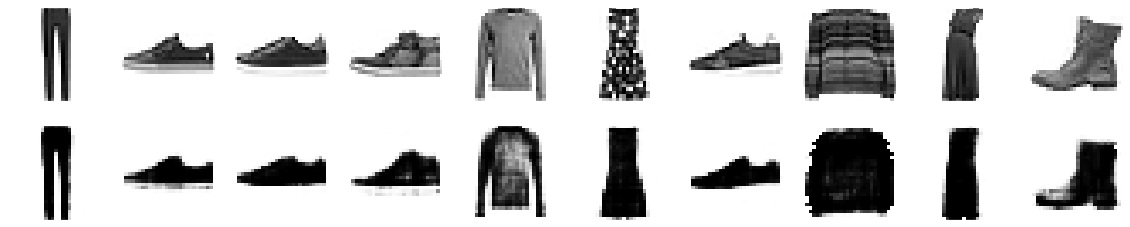

In [85]:
show_autoencoder_sample(encoder_84, decoder_84)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 0.8508 - accuracy: 0.7135 - val_loss: 0.5220 - val_accuracy: 0.8179
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4858 - accuracy: 0.8310 - val_loss: 0.4562 - val_accuracy: 0.8420
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4338 - accuracy: 0.8508 - val_loss: 0.4232 - val_accuracy: 0.8539
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4036 - accuracy: 0.8600 - val_loss: 0.4103 - val_accuracy: 0.8583
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3835 - accuracy: 0.8677 - val_loss: 0.3921 - val_accuracy: 0.8641
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3670 - accuracy: 0.8724 - val_loss: 0.3940 - val_accuracy: 0.8597
Epoch 7/64
48000/48000 [===========

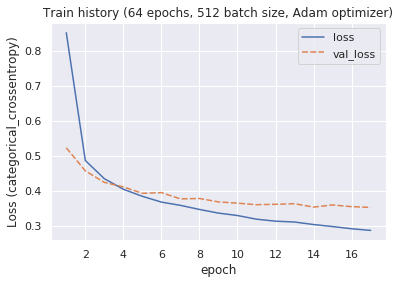

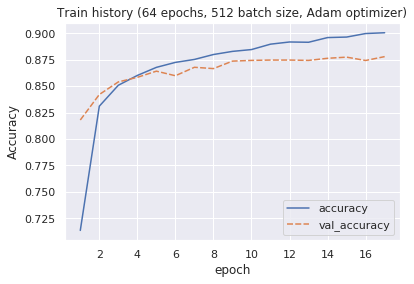

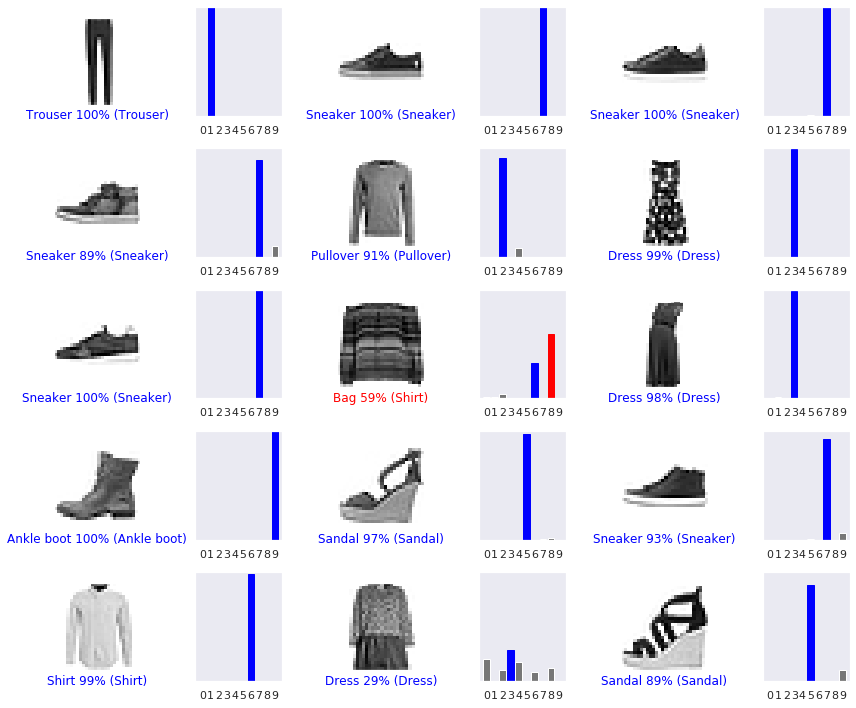

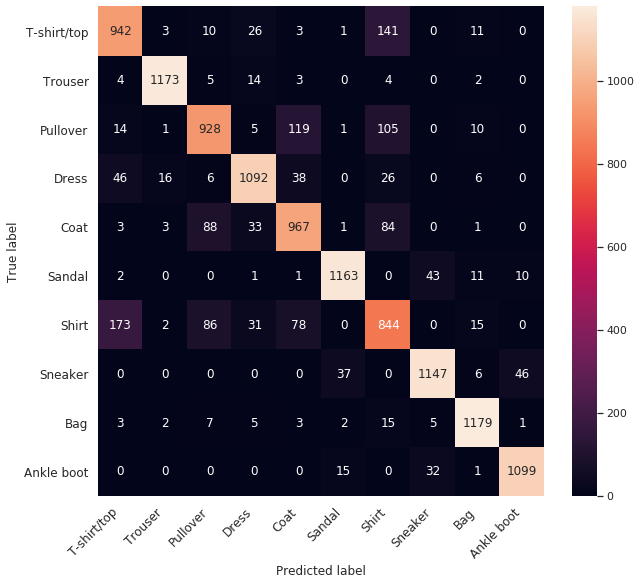

In [86]:
Y_val_ae_84_pred, model_ae_84 = train_ae_model(encoder_84, latent_dim, model_name="AE_84")

In [87]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_84_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7936  |  0.8285  |  0.8107
Class 1 (Trouser):       0.9775  |  0.9734  |  0.9755
Class 2 (Pullover):      0.8212  |  0.7844  |  0.8024
Class 3 (Dress):         0.9047  |  0.8878  |  0.8962
Class 4 (Coat):          0.7979  |  0.8195  |  0.8085
Class 5 (Sandal):        0.9533  |  0.9448  |  0.9490
Class 6 (Shirt):         0.6924  |  0.6867  |  0.6895
Class 7 (Sneaker):       0.9348  |  0.9280  |  0.9314
Class 8 (Bag):           0.9493  |  0.9648  |  0.9570
Class 9 (Ankle boot):    0.9507  |  0.9582  |  0.9544

Combined F1 score:  0.8675
Combined Precision: 0.8675
Combined Recall:    0.8674


### 3.2. Latent vector size of 24

In [0]:
latent_dim = 24

In [89]:
autoencoder_24, encoder_24, decoder_24 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                18840     
_________________________________________________________________
dense_25 (Dense)             (None, 784)               19600     
Total params: 38,440
Trainable params: 38,440
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                1884

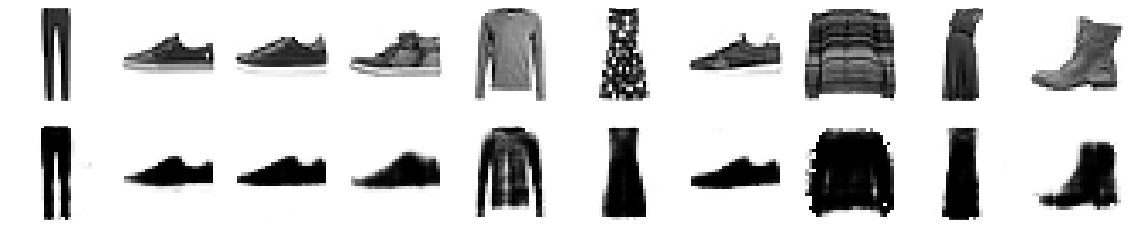

In [90]:
show_autoencoder_sample(encoder_24, decoder_24)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 1.1502 - accuracy: 0.6521 - val_loss: 0.5855 - val_accuracy: 0.7918
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.5452 - accuracy: 0.8114 - val_loss: 0.5108 - val_accuracy: 0.8167
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4931 - accuracy: 0.8270 - val_loss: 0.4789 - val_accuracy: 0.8292
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4649 - accuracy: 0.8366 - val_loss: 0.4589 - val_accuracy: 0.8358
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4434 - accuracy: 0.8457 - val_loss: 0.4497 - val_accuracy: 0.8416
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4309 - accuracy: 0.8491 - val_loss: 0.4368 - val_accuracy: 0.8435
Epoch 7/64
48000/48000 [===========

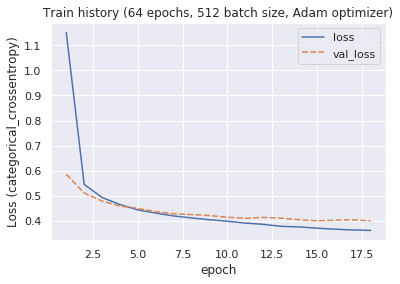

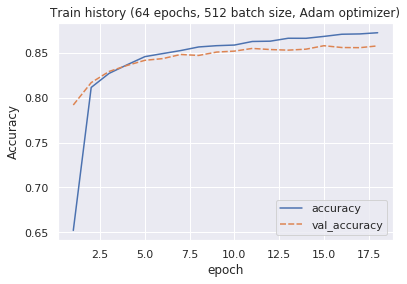

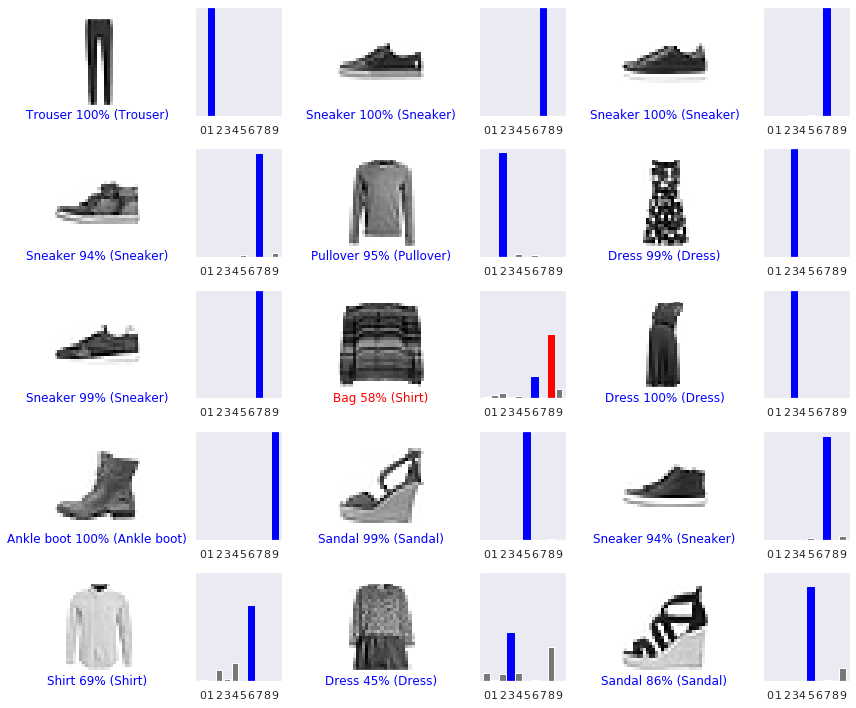

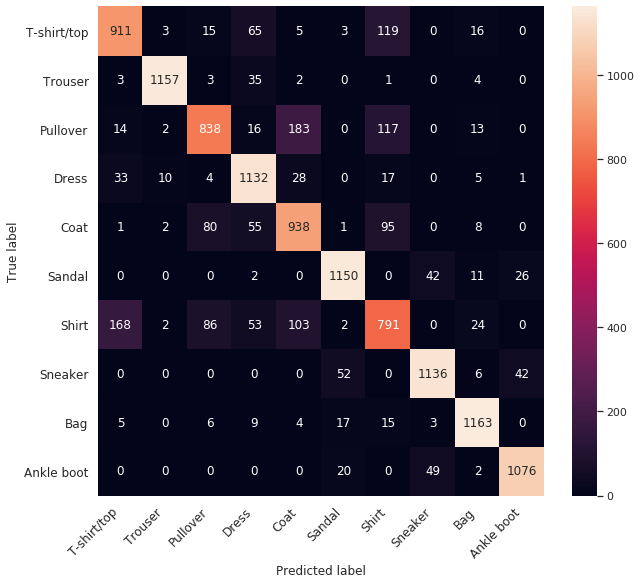

In [91]:
Y_val_ae_24_pred, model_ae_24 = train_ae_model(encoder_24, latent_dim, model_name="AE_24")

In [92]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_24_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8026  |  0.8012  |  0.8019
Class 1 (Trouser):       0.9838  |  0.9602  |  0.9719
Class 2 (Pullover):      0.8120  |  0.7084  |  0.7567
Class 3 (Dress):         0.8281  |  0.9203  |  0.8718
Class 4 (Coat):          0.7427  |  0.7949  |  0.7679
Class 5 (Sandal):        0.9237  |  0.9342  |  0.9289
Class 6 (Shirt):         0.6848  |  0.6436  |  0.6636
Class 7 (Sneaker):       0.9236  |  0.9191  |  0.9213
Class 8 (Bag):           0.9289  |  0.9517  |  0.9402
Class 9 (Ankle boot):    0.9397  |  0.9381  |  0.9389

Combined F1 score:  0.8443
Combined Precision: 0.8464
Combined Recall:    0.8421


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.

In [0]:
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import adjusted_rand_score

In [0]:
def show_clusters(clusters, data):
    print("Clusters:", set(clusters.labels_))

    print("Adjusted Rand Score:", adjusted_rand_score(ys_val, clusters.labels_))

    labels = clusters.labels_.astype(float)
    centroids = clusters.cluster_centers_

    __xs, __ys = data[..., 0], data[..., 1]

    plt.scatter(x=__xs, y=__ys,
                c=labels, s=50, alpha=0.8, cmap="viridis")
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='+', s=169, linewidths=3, color='red', zorder=10)
    plt.show()

## 4.1. K-Means

In [0]:
# FIXME Autoencoder clustering looks really odd

### 4.1.1. Autoencoder reduced features (24 latent vector size)

In [0]:
X_val_ae_24 = encoder_24.predict(X_val)

In [0]:
kmeans_ae_24 = KMeans(n_clusters=10).fit(X_val_ae_24)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3569372444415326


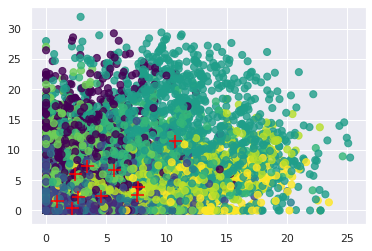

In [153]:
show_clusters(kmeans_ae_24, X_val_ae_24)

### 4.1.2. Autoencoder reduced features (84 latent vector size)

In [0]:
X_val_ae_84 = encoder_84.predict(X_val)

In [0]:
kmeans_ae_84 = KMeans(n_clusters=10).fit(X_val_ae_84)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3692659247094154


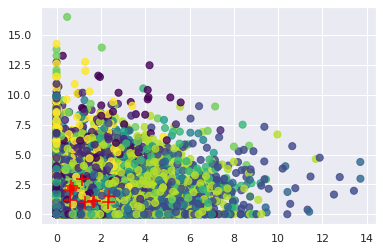

In [148]:
show_clusters(kmeans_ae_84, X_val_ae_84)

### 4.1.3. PCA reduced features (80% explained variance, 24 principal components)

In [0]:
X_val_80var = pca_80var.transform(X_val)

In [0]:
kmeans_pca_80var = KMeans(n_clusters=10).fit(X_val_80var)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.3699988613546312


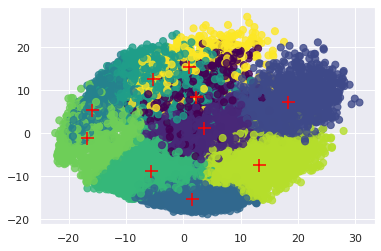

In [144]:
show_clusters(kmeans_pca_80var, X_val_80var)

### 4.1.4. PCA reduced features (90% explained variance, 84 principal components)

In [0]:
X_val_90var = pca_90var.transform(X_val)

In [0]:
kmeans_pca_90var = KMeans(n_clusters=10).fit(X_val_90var)

Clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Adjusted Rand Score: 0.34605184850818943


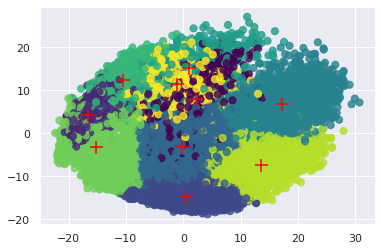

In [141]:
show_clusters(kmeans_pca_90var, X_val_90var)

In [0]:
# TODO run another method

In [94]:
strftime('%X')

'20:48:20'